# UD120 - Classifing Enron POIs

# Introduction

In 2000, Enron was one of the largest companies in the United States. Two years later, it became bankrupt due to widespread corporate fraud. In the resulting Federal investigation, normally confidential information, including tens of thousands of emails and detailed financial data for top executives, entered the public record.

The objective of this project is to build an algorithm to identify Enron employees who may have committed fraud based on the public Enron financial and email dataset. Such employees are referred to as "person's of interest", or, POIs.

## Data Overview

The dataset provided for this projection is a dictionary containing combined Enron email and financial data. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into two major types; financial features and email features. Each person is also labelled as a poi (boolean). A summary of the features is provided below:

**financial features**:
* salary
* deferral_payments
* total_payments
* loan_advances
* bonus
* restricted_stock_deferred
* deferred_income
* total_stock_value
* expenses
* exercised_stock_options
* other
* long_term_incentive
* restricted_stock
* director_fees
* (all units are in US dollars)

**email features**
* to_messages
* email_address
* from_poi_to_this_person
* from_messages
* from_this_person_to_poi
* shared_receipt_with_poi
* (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

Using this information, a predictive model can be developed based on patterns in salaries, bonuses, and/or email metadata among the POIs.

The remainder of the report outlines the data exploration, feature selection, feature engineering and model development steps.

# Data Exploration

The required packages for data processing, visualization and model development are imported.

In [328]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [329]:
## modelling packages
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest
from feature_format import featureFormat, targetFeatureSplit
import tester

In [330]:
## initiate seaborn plotting
import matplotlib.pyplot as plt
import seaborn as sns
p = sns.color_palette()

In [336]:
## import dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    my_dataset = pickle.load(data_file)

# read into dataframe
df = pd.DataFrame.from_dict(my_dataset,orient='index')
df = df.replace('NaN',np.nan)

## Outlier Detection

To detect any outliers in the dataset, I start by plotting employee salaries and bonuses to see if any employees are receiving payments that are magnitudes larger than others.

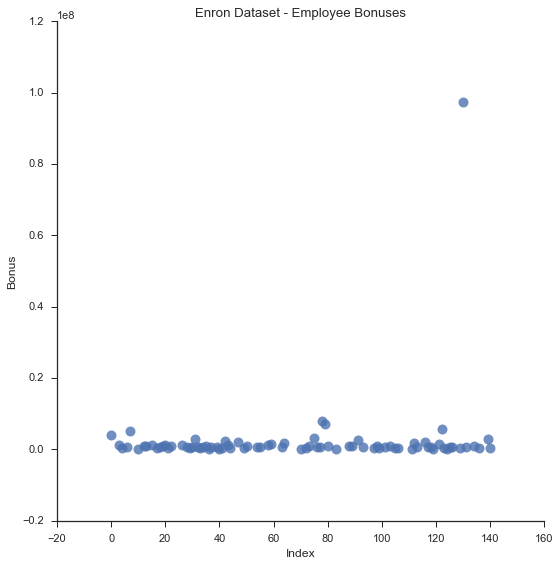

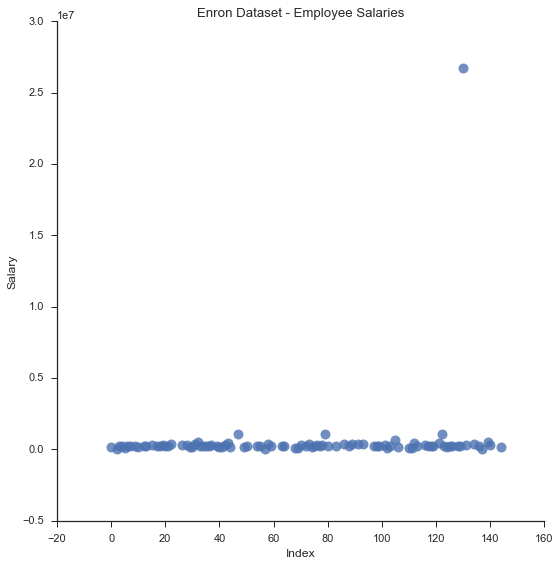

In [337]:
##create a dummy index field for plotting
df['name'] = df.index
df = df.reset_index()
df['index'] = df.index

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

sns.lmplot('index', 'bonus', 
           data=df,
           fit_reg=False, 
           scatter_kws={"marker": "D", 
                        "s": 100},
          size=8);
plt.title('Enron Dataset - Employee Bonuses');
plt.xlabel('Index');
plt.ylabel('Bonus');

sns.lmplot('index', 'salary', 
           data=df,
           fit_reg=False, 
           scatter_kws={"marker": "D", 
                        "s": 100},
          size=8);
plt.title('Enron Dataset - Employee Salaries');
plt.xlabel('Index');
plt.ylabel('Salary');

Right away, a large outlier becomes apparent. Upon further investigation, the outlier is a result of a "TOTAL" field being present in the dictionary that sums each field for all employees in the dataset.

The "total" field is removed, and the same fields are re-plotted below.

In [338]:
# remove outlier
my_dataset.pop('TOTAL');

## recreate dataframe
df = pd.DataFrame.from_dict(my_dataset,orient='index')
df = df.replace('NaN',np.nan)
df['name'] = df.index
df = df.reset_index()
df['index'] = df.index

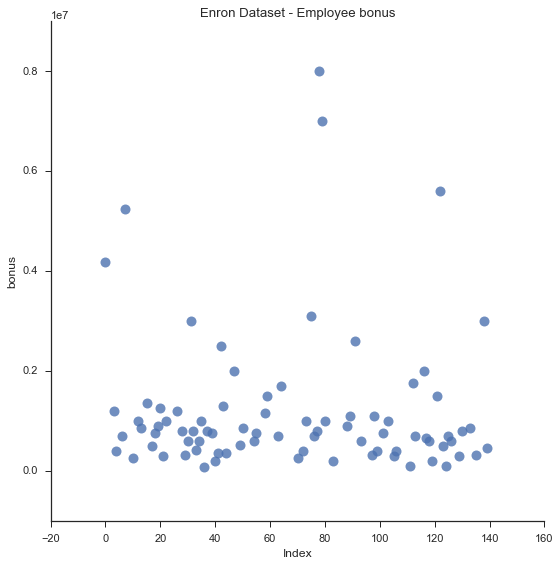

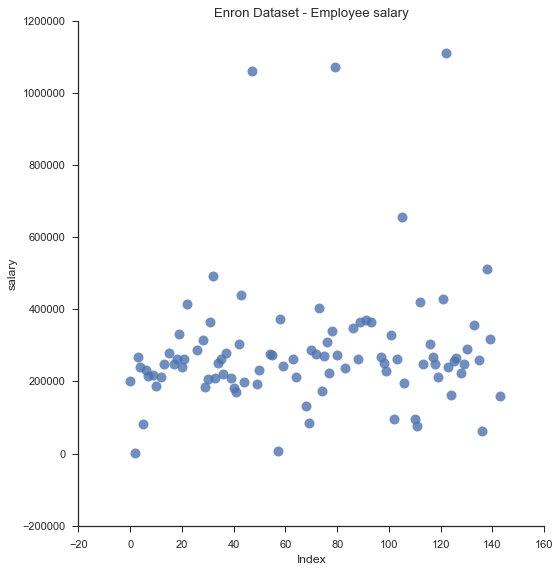

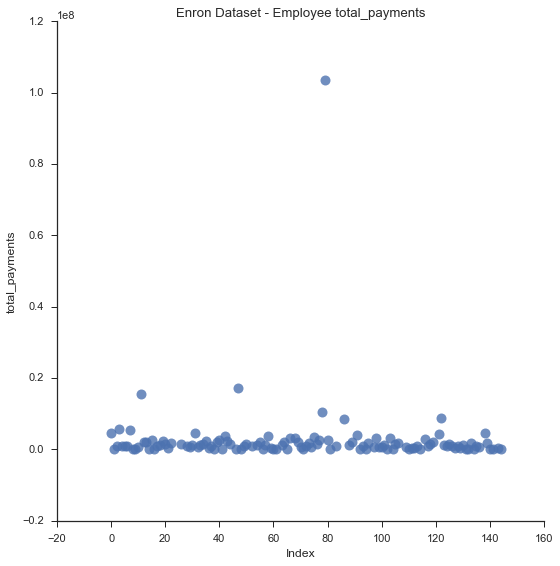

In [339]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")


for payment_feature in ['bonus','salary','total_payments']:

    sns.lmplot('index', payment_feature, 
               data=df,
               fit_reg=False, 
               scatter_kws={"marker": "D", 
                            "s": 100},
              size=8);
    plt.title('Enron Dataset - Employee %s' % payment_feature);
    plt.xlabel('Index');
    plt.ylabel(payment_feature);

With the new dataset, it appears there are still some outliers, particularly in the total_payments plot.

In [340]:
## other potential outliers
df[(df.salary > 1000000) | (df.bonus > 5000000)][['bonus','salary','poi','total_payments']]

,bonus,salary,poi,total_payments
7,5249999,213999,True,5501630
47,2000000,1060932,False,17252530
78,8000000,339288,False,10425757
79,7000000,1072321,True,103559793
122,5600000,1111258,True,8682716


The majority of the remaining potential outliers belong to POIs. With only 18 POIs in the dataset, removing these points is not a viable option.

### Data Overview

A summary of dataset is provided below, including information on:
* Total number of POIs in the dataset
* Total number of employees in the dataset
* Number of features in the dataset
* Number of non-missing values for each feature
* Number of non-missing values for each feature, for the POI population


The dataset contains a total of 18 POIs.


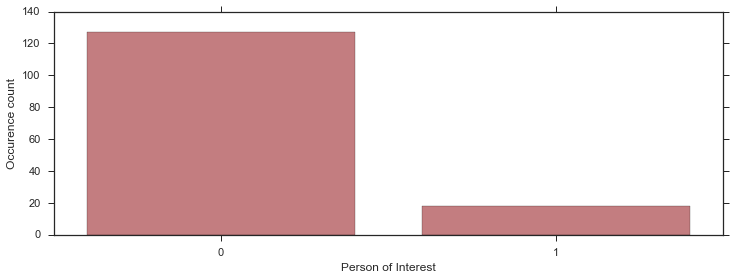

In [341]:
# code True/False poi's as 1's and 0's
df['poi'] = df['poi'].apply(lambda x: 1 if x else 0)

# total number of poi's in the dataset
poi = df.poi.value_counts()

plt.figure(figsize=(12,4));
sns.barplot(poi.index, poi.values, alpha=0.8, color=p[2]);
plt.xlabel('Person of Interest', fontsize=12);
plt.ylabel('Occurence count', fontsize=12);

print ('The dataset contains a total of %s POIs.' % sum(df['poi']))

In [342]:
print ('The dataset contains %s total records, with %s features for each record' % (df.shape[0], df.shape[1]-2))

The dataset contains 145 total records, with 21 features for each record


In [343]:
all = df.count()

## features counts for the poi's
pois = df[df['poi'] == 1].count()

result = pd.concat([all, pois], axis=1)
result.columns = ['All Records','POIs']
result

,All Records,POIs
index,145,18
to_messages,86,14
restricted_stock_deferred,17,0
poi,145,18
deferred_income,48,11
salary,94,17
total_stock_value,125,18
expenses,94,18
deferral_payments,38,5
director_fees,16,0


## Selected Features

The table above shows the dataset completeness for each feature, by showing counts of non-missing values for each feature among the total population, and the POI population. As shown in the "All Records" column, no features have information for every employee in the dataset. For example, information on loan advances is available for only 3 employees in the entire dataset. 

For the POI population, the restricted_stock_deferred, director_fees, loan_advances and deferral_payments features are missing for more than 50% of the POI population. As a result, these features were omitted from the modelling process. The email_address feature is also left out since it is text-based, and intuitively provides no predtictive value.

In [372]:
features_list = ['poi','to_messages', 'deferred_income',
       'salary', 'total_stock_value', 'expenses', 'restricted_stock',
       'from_poi_to_this_person', 'long_term_incentive',
       'from_this_person_to_poi', 'total_payments', 'exercised_stock_options',
       'other', 'from_messages', 'bonus', 'shared_receipt_with_poi'] 

## Feature Distributions

For each feature, the data distributions are plotted to determine if feature scaling is required.

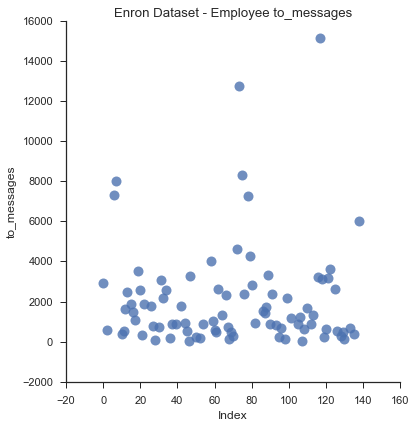

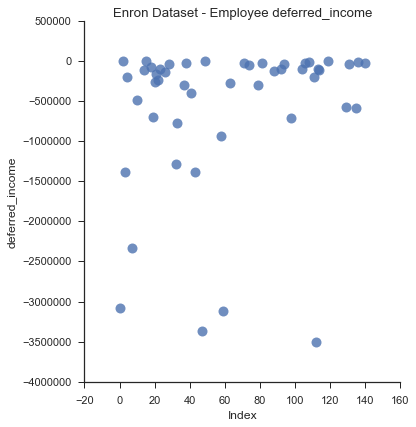

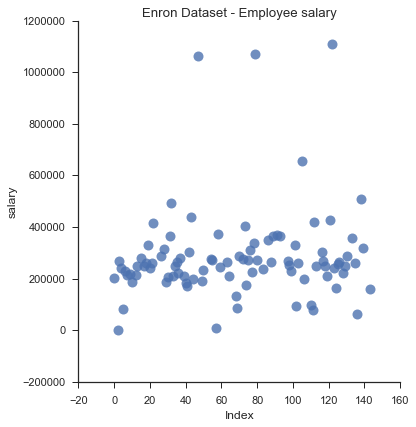

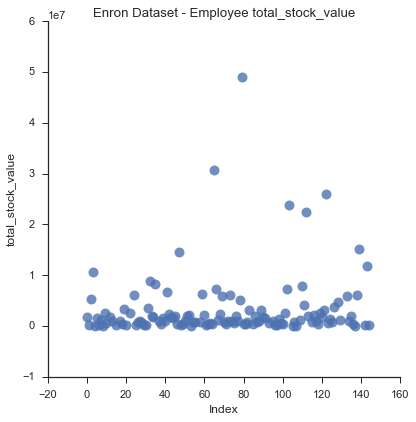

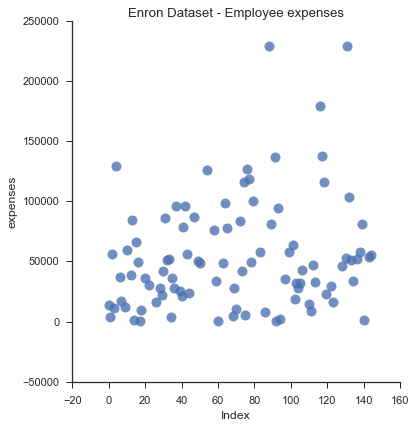

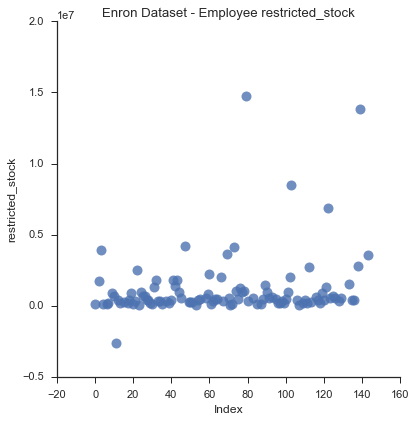

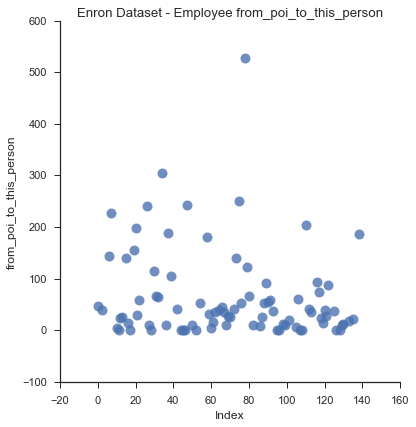

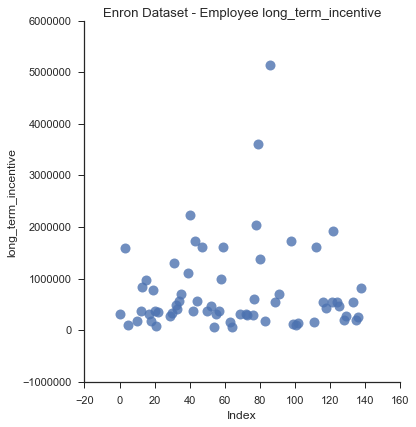

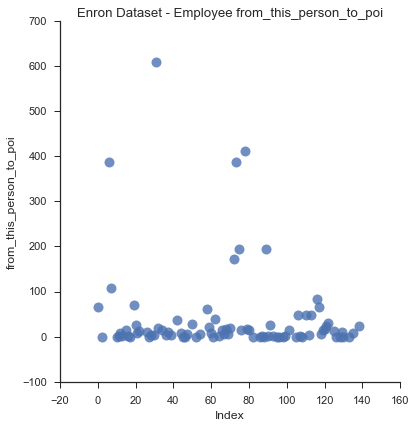

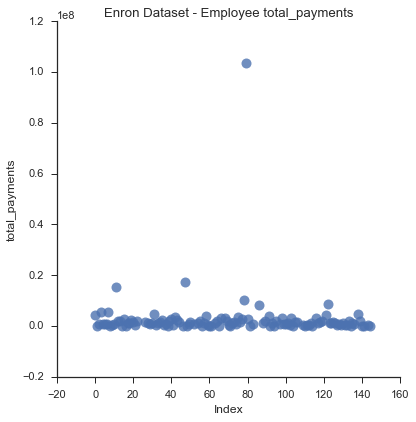

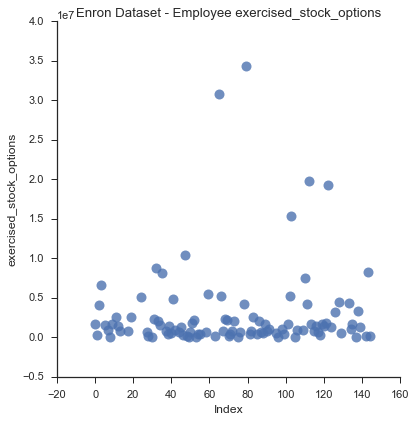

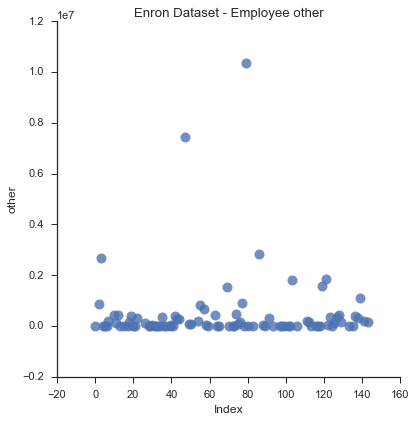

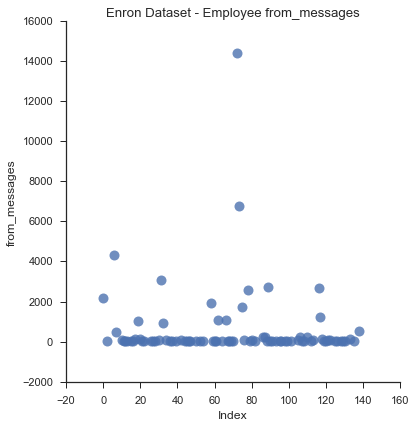

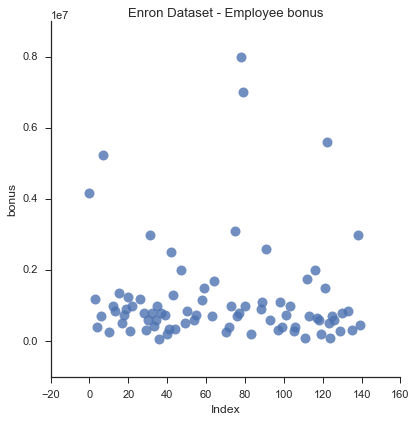

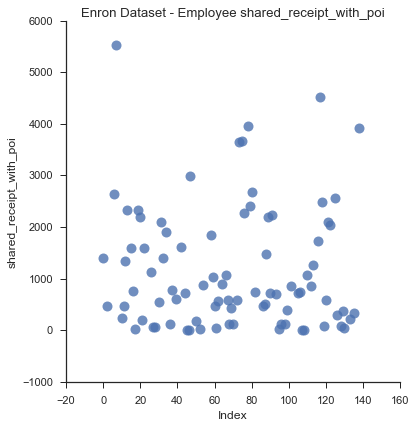

In [346]:
for feature in features_list[1:]: ##ignore first feature which is poi label
    try:
        sns.lmplot('index', feature, 
                   data=df,
                   fit_reg=False, 
                   scatter_kws={"marker": "D", 
                                "s": 100},
                  size=6);
        plt.title('Enron Dataset - Employee %s' % feature);
        plt.xlabel('Index');
        plt.ylabel(feature);
    except:
        pass


Some feature distributions are skewed by having a few large outliers (i.e. from_messages, other, total_payments).

While random-forests algorithms are able to handle un-scaled features, other algorithms, like SVMs, cannot. From sklearn's documentation:

*Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
[Source](http://scikit-learn.org/stable/modules/preprocessing.html)*


As a result, sklearn's preprocessing package is used for feature scaling prior to modelling.

## Feature Engineering

Both the financial and email features are raw counts or values. More informative features can be created by comparing the individual values. For example, seeing how much of an employees total compensation comes from their bonus, or salary, could potentially be more informative than the salary/bonus alone. Similarly, seeing how frequently a person communicates with a POI compared to non-POIs is potentially more useful than a raw count. Based on these ideas, the following features are created:

1. **frac_bonus** - the portion of an employees total compensation that is made up by their bonus
2. **frac_salary** - the portion of an employees total compensation that is made up by their base salary
3. **frac_tot_stock** - the portion of an employees total compensation that is made up by their total stock value
4. **frac_to_poi** - the fraction of emails an employee sends to a POI out of all their sent mail
5. **frac_from_poi** - the fraction of emails an employee receives from a POI out of all their incoming mail

In [348]:
df['frac_bonus'] = df['bonus']/df['total_payments']
df['frac_salary'] = df['salary']/df['total_payments']
df['frac_tot_stock'] = df['total_stock_value']/df['total_payments']

df['frac_to_poi'] = df['from_this_person_to_poi']/df['to_messages']
df['frac_from_poi'] = df['from_poi_to_this_person']/df['to_messages']

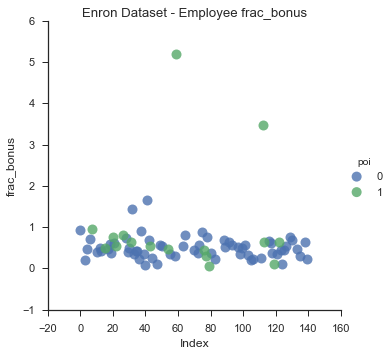

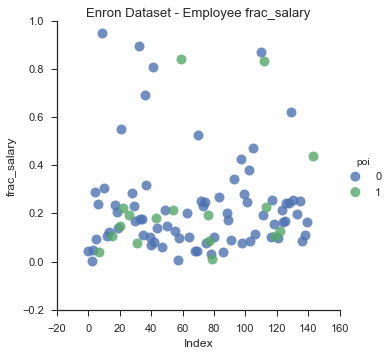

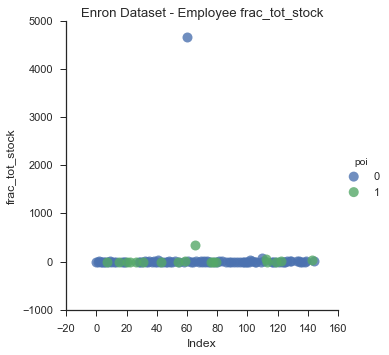

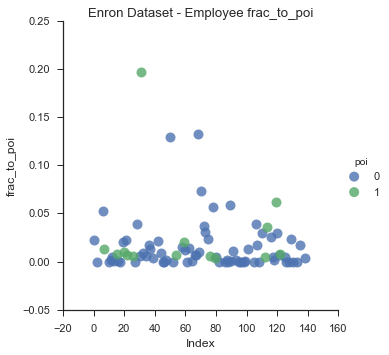

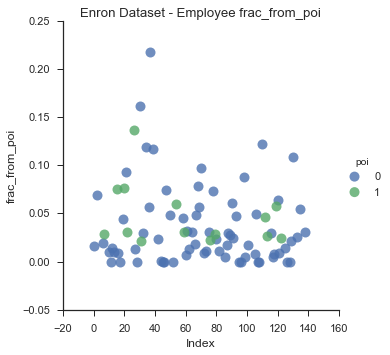

In [351]:
new_features = ['frac_bonus','frac_salary','frac_tot_stock','frac_to_poi','frac_from_poi']
for feature in new_features:
    sns.lmplot('index', feature, 
           data=df, 
           fit_reg=False, 
           hue="poi",  
           scatter_kws={"marker": "D", 
                        "s": 100},
           size =5 )
    plt.title('Enron Dataset - Employee %s' % feature);
    plt.xlabel('Index');
    plt.ylabel(feature);

In [253]:
df = df.fillna('NaN')
dataset = df.T.to_dict()

# Modelling & Validation

Based on sklearn's algorithm selection [decision tree](http://scikit-learn.org/stable/tutorial/machine_learning_map/), three canditate models are explored:

* Support vector machines (SVMs)
* KNeighbours Classifier
* Random Forests

**Feature Scaling and Parameter Tuning**

To support feature scaling and parameter tuning, sklearn's pipeline and GridSearch modules are deployed. Pipelines can be used to assemble several steps that can be cross-validated together while setting different parameters. Parameter tuning is a very important step in machine learning. Practically all machine learning algorithms require various parameters to be set upon creation. As demonstrated throughout the UD120 course, the values of the parameters can have a major impact on the model performance. The goal for all machine learning practitioners is to find the parameter values that yield optimal performance. Sklearn's GridSearchCV module automates this process by performing a grid search over a range of parameter values for an estimator. 

Feature selection is achieved using the SelectKBest method with a grid search to optimize the number of selected features.

**Model Metrics and Validation**

Models are created for the base features, and the engineered featureset which contains both base features and the new "fractional" features developed. The models are compared using the validation metrics discussed below.

Validation of a model is required to ensure that the model will perform consistently across various datasets/samples. In most practices, validation is performed by splitting data into training and testing sets, where neither set contains the same records. By doing this, the model's performance can be "validated" on the testing dataset, which it has not seen before. Validation helps ensure the model is not overfitted and only performs well on the trained dataset.


Each model will be scored using the *test_classifier* function from *tester.py*. This function returns the model's precision and recall. At a high level, a classifier's precision is its ability to correctly label POIs without having a lot of false positives. Recall measures how many POIs are identified by the model. It is important to measure both of these metrics, since certain algorithms could achieve high recall (by identifying close to all POIs), with lots of false positives (low precision), and vice versa.

In the *test_classifier* function, sklearn's StratifiedShuffleSplit module is used to create training and test sets. In the function, the classifier is fit to the training set, then predicted values are produced, scored and reported for the training set. This method is employed as it preserves a percentage of samples for each class. This is important since the POIs represent a small portion of the dataset. 


## Base Featureset

In [353]:
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### SVM Model

In [354]:
## SVM Model
from sklearn import svm
svm = Pipeline([('scaler',StandardScaler()),('svm',svm.SVC())])
param_grid = ([{'svm__C': [1,50,100,1000],
                'svm__gamma': [0.5, 0.1, 0.01],
                'svm__degree':[1,2],
                'svm__kernel': ['rbf','poly']}])

svm_clf = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(svm_clf, dataset, features_list)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.84660	Precision: 0.40208	Recall: 0.30900	F1: 0.34945	F2: 0.32400
	Total predictions: 15000	True positives:  618	False positives:  919	False negatives: 1382	True negatives: 12081



Based on the results of the grid search, the optimal SVM classifier uses a poly kernel, has a C value of 100, gamma of 0.1 and degree of 2.

### Random Forests

In [355]:
### Random Forests Model
rfm = Pipeline([('scaler',StandardScaler()),('rf',RandomForestClassifier())])
param_grid = ([{'rf__n_estimators': [4,5,7,8]}])
rf_clf = GridSearchCV(rfm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(rf_clf, dataset, features_list)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.84607	Precision: 0.34023	Recall: 0.16450	F1: 0.22177	F2: 0.18345
	Total predictions: 15000	True positives:  329	False positives:  638	False negatives: 1671	True negatives: 12362



In [357]:
### Random Forests Model WITHOUT SCALER
rfm = Pipeline([('rf',RandomForestClassifier())])
param_grid = ([{'rf__n_estimators': [4,5,7,8]}])
rf_clf = GridSearchCV(rfm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(rf_clf, dataset, features_list)

Pipeline(steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.83987	Precision: 0.32149	Recall: 0.18100	F1: 0.23161	F2: 0.19833
	Total predictions: 15000	True positives:  362	False positives:  764	False negatives: 1638	True negatives: 12236



Feature scaling appears to have an insignificant effect on the Random Forests model, as expected.

### K-Nearest Neighbours

In [358]:
### K-Nearest Neighbours Model
knb = Pipeline([('scaler', StandardScaler()),('knb', KNeighborsClassifier())])
param_grid = ([{'knb__n_neighbors': [2,3,4,5,6,7]}])
knb_clf = GridSearchCV(knb, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(knb_clf, dataset, features_list)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knb', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform'))])
	Accuracy: 0.86573	Precision: 0.47200	Recall: 0.05900	F1: 0.10489	F2: 0.07152
	Total predictions: 15000	True positives:  118	False positives:  132	False negatives: 1882	True negatives: 12868



The K-Nearest Neighbours model has the highest accuracy and precision, but the lowest recall.

## Engineered Featureset

In [373]:
## add new features
features_list += new_features
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
feature_list = features_list[1:]

### SVM Model

In [360]:
### SVM Model
from sklearn import svm
svm = Pipeline([('scaler',StandardScaler()),('kbest',SelectKBest()), ('svm',svm.SVC())])

param_grid = ([{'svm__C': [1],
                'svm__gamma': [0.5, 0.1, 0.01],
                'svm__degree':[1,2],
                'svm__kernel': ['rbf','poly'],
                'kbest__k':[10,20,'all']}])

svm_clf = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(svm_clf, dataset, features_list)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=20, score_func=<function f_classif at 0x1160c28c8>)), ('svm', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=0.5, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.85347	Precision: 0.35224	Recall: 0.11800	F1: 0.17678	F2: 0.13610
	Total predictions: 15000	True positives:  236	False positives:  434	False negatives: 1764	True negatives: 12566



In [374]:
## source : http://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
feature_scores = sorted({feature_list[i]:rf_clf.get_params()['kbest'].scores_[i]
                         for i in range(0,20)}.items(), reverse=True, key=operator.itemgetter(1))
feature_scores

[('exercised_stock_options', 22.846900557039735),
 ('total_stock_value', 22.334566139036529),
 ('salary', 16.960916240556603),
 ('bonus', 15.4914145509044),
 ('frac_bonus', 12.563570822691718),
 ('restricted_stock', 8.6100114666718408),
 ('total_payments', 8.5062385749366047),
 ('shared_receipt_with_poi', 7.0633985713746013),
 ('deferred_income', 6.1946652916933163),
 ('long_term_incentive', 5.6633149245911412),
 ('expenses', 5.2838455291937203),
 ('from_poi_to_this_person', 5.0503691628537695),
 ('other', 4.4218072883174111),
 ('frac_from_poi', 3.5744989363705773),
 ('to_messages', 1.4869429249474853),
 ('frac_salary', 1.3414085864631289),
 ('from_messages', 0.8114229919635324),
 ('frac_to_poi', 0.62684051718516975),
 ('frac_tot_stock', 0.024576561791928627),
 ('from_this_person_to_poi', 0.0078322292841794781)]

The addition of the engineered features actually reduces the performance of the SVM model. The rank-ordered features (based on SelectKBest scores) show that the engineered features are among the weakest.

### Random Forests

In [361]:
### Random Forests Model
rfm = Pipeline([('scaler',StandardScaler()), ('kbest',SelectKBest()), ('rf',RandomForestClassifier())])
param_grid = ([{'rf__n_estimators': [4,5,7,8],
               'kbest__k':[10,15,20,'all']}])
rf_clf = GridSearchCV(rfm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(rf_clf, dataset, features_list)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x1160c28c8>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_node...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.84060	Precision: 0.34221	Recall: 0.21200	F1: 0.26181	F2: 0.22946
	Total predictions: 15000	True positives:  424	False positives:  815	False negatives: 1576	True negatives: 12185



In [375]:
## source : http://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value
feature_scores = sorted({feature_list[i]:rf_clf.get_params()['kbest'].scores_[i]
                         for i in range(0,10)}.items(), reverse=True, key=operator.itemgetter(1))
feature_scores

[('total_stock_value', 22.334566139036529),
 ('salary', 16.960916240556603),
 ('restricted_stock', 8.6100114666718408),
 ('total_payments', 8.5062385749366047),
 ('deferred_income', 6.1946652916933163),
 ('long_term_incentive', 5.6633149245911412),
 ('expenses', 5.2838455291937203),
 ('from_poi_to_this_person', 5.0503691628537695),
 ('to_messages', 1.4869429249474853),
 ('from_this_person_to_poi', 0.0078322292841794781)]

In the Random Forests model, none of the engineered features are in the selected features.

### K-Nearest Neighbours

In [362]:
### K-Nearest Neighbours Model
knb = Pipeline([('scaler', StandardScaler()), ('kbest',SelectKBest()), ('knb', KNeighborsClassifier())])
param_grid = ([{'knb__n_neighbors': [2,3,4,5,6,7], 
                'kbest__k':[10,15,20,'all']}])
knb_clf = GridSearchCV(knb, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(knb_clf, dataset, features_list)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=20, score_func=<function f_classif at 0x1160c28c8>)), ('knb', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])
	Accuracy: 0.84840	Precision: 0.28185	Recall: 0.08850	F1: 0.13470	F2: 0.10257
	Total predictions: 15000	True positives:  177	False positives:  451	False negatives: 1823	True negatives: 12549



The precision of the K-Nearest Neighbours model decreased with the new features, while its recall increased slightly.

### Final Model

By using both precision and recall metrics, the SVM model had the strongest performance out of the 3 classifiers. As a result, it was chosen as the final model. Based on the grid search results, the following parameters are used in the final model:

* C=100
* gamma=0.1
* degree=2
* kernel='poly'

Based on the weaker performance of the models with the new features, the base featureset is used for the final model. From the SelectKBest feature selection method, all base features were included.


In [379]:
features_list = ['poi','to_messages', 'deferred_income',
       'salary', 'total_stock_value', 'expenses', 'restricted_stock',
       'from_poi_to_this_person', 'long_term_incentive',
       'from_this_person_to_poi', 'total_payments', 'exercised_stock_options',
       'other', 'from_messages', 'bonus', 'shared_receipt_with_poi'] 
data = featureFormat(dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
feature_list = features_list[1:]

In [380]:
from sklearn import svm

svm = Pipeline([('scaler',StandardScaler()),("kbest", SelectKBest()),('svm',svm.SVC())])
param_grid = ([{'svm__C': [100],'svm__gamma': [0.1],'svm__degree':[2],'svm__kernel': ['poly'],'kbest__k':['all']}])
svm_clf = GridSearchCV(svm, param_grid, scoring='recall').fit(features, labels).best_estimator_

tester.test_classifier(svm_clf, dataset, features_list)

## show feature scores for final features
feature_scores = sorted({feature_list[i]:svm_clf.get_params()['kbest'].scores_[i]
                         for i in range(0,len(feature_list))}.items(), reverse=True, key=operator.itemgetter(1))
feature_scores

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k='all', score_func=<function f_classif at 0x1160c28c8>)), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.84660	Precision: 0.40208	Recall: 0.30900	F1: 0.34945	F2: 0.32400
	Total predictions: 15000	True positives:  618	False positives:  919	False negatives: 1382	True negatives: 12081



[('exercised_stock_options', 22.846900557039735),
 ('total_stock_value', 22.334566139036529),
 ('salary', 16.960916240556603),
 ('bonus', 15.4914145509044),
 ('restricted_stock', 8.6100114666718408),
 ('total_payments', 8.5062385749366047),
 ('shared_receipt_with_poi', 7.0633985713746013),
 ('deferred_income', 6.1946652916933163),
 ('long_term_incentive', 5.6633149245911412),
 ('expenses', 5.2838455291937203),
 ('from_poi_to_this_person', 5.0503691628537695),
 ('other', 4.4218072883174111),
 ('to_messages', 1.4869429249474853),
 ('from_messages', 0.8114229919635324),
 ('from_this_person_to_poi', 0.0078322292841794781)]

# Conclusion

The final SVM model has a precision of 0.40, a recall of 0.31, and an accuracy of 0.85. While the model was the best performing of the 3 classifiers studied, it is generally not very accurate based on the metrics provided. 

The 40% precision means that for every 10 people the SVM predicted to be POIs, and only 4 of them are actually POIs.
The 31% recall means that if there were 100 true POIs in the dataset, the SVM would only identify 31 of them.

For future investigations, it is recommended to build additional features, potentially creating text based features from the raw emails.